In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
df_train = pd.read_csv("train_df.csv")
df_test = pd.read_csv("test_df.csv")

# Charger embeddings
df_train_emb = pd.read_csv("train_embeddings.csv")
df_test_emb  = pd.read_csv("test_embeddings.csv")


tab_features = [
    # Transaction
    "amt",
    "hour",
    "is_night_tx",
    "is_new_merchant",
    "dist_from_home",
    "is_impossible_travel",
    "is_category_shift",
    
    # Card
    "amt_zscore",
    "amt_vs_card_mean_ratio",
    "amt_minus_prev_max",
    "card_amt_std",
    "tx_count_1h",
    "tx_count_24h",
    "amt_sum_1h",
    
    # Merchant
    "merchant_avg_amt",
    "merchant_time_since_prev_tx",
    "amt_vs_merchant_avg_ratio"
]


In [51]:
# Extraire embeddings
Z_train = df_train_emb.filter(regex="^z_").values
tx_train = df_train_emb["transaction_id"].values

# Vérification IDs
missing_train = set(tx_train) - set(df_train["transaction_id"])
assert len(missing_train) == 0, f"Transactions manquantes dans df_train: {missing_train}"

# Extraire features tabulaires
X_tab_train = df_train.set_index("transaction_id").loc[tx_train, tab_features].values

# Concaténer
X_train = np.hstack([Z_train, X_tab_train])


In [52]:
Z_test = df_test_emb.filter(regex="^z_").values
tx_test = df_test_emb["transaction_id"].values

missing_test = set(tx_test) - set(df_test["transaction_id"])
assert len(missing_test) == 0, f"Transactions manquantes dans df_test: {missing_test}"

X_tab_test = df_test.set_index("transaction_id").loc[tx_test, tab_features].values

X_test = np.hstack([Z_test, X_tab_test])

In [53]:
# Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [54]:
# Entraîner IF sur train
iso = IsolationForest(
    n_estimators=400,
    max_samples='auto',
    contamination=0.005,
    max_features=1.0,
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)

# Score anomalie
scores_test  = -iso.decision_function(X_test)

df_test_emb["if_score"]  = scores_test

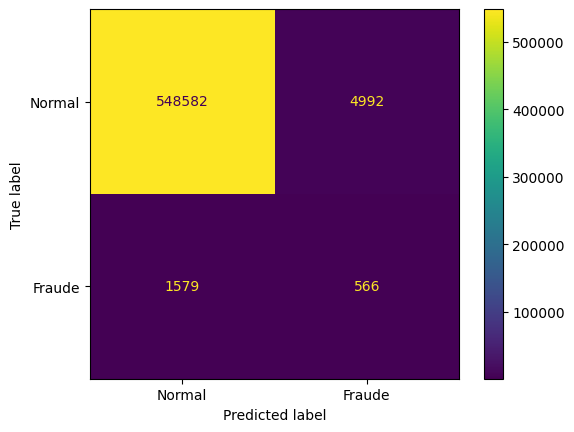

In [55]:
y_true = df_test_emb["label"].values

# Définir un seuil
# top 1% comme anomalies
threshold = df_test_emb["if_score"].quantile(0.99)

# Créer prédiction binaire
y_pred = (df_test_emb["if_score"] >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Fraude"]
)
disp.plot()


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
ap = average_precision_score(y_true, df_test_emb["if_score"])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap:.4f}")


Precision: 0.1018, Recall: 0.2639, F1: 0.1470, AP: 0.0630
